In [3]:
import os
import pandas as pd
from PIL import Image



import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader


import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from time import time

from sklearn.metrics import f1_score

import torch
import torch.utils.data as data

import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data_dir = '/opt/ml/input/data/train'
img_dir = f'{data_dir}/crop_images'
df_path = f'{data_dir}/train.csv'

In [5]:
train_label = pd.read_csv("/opt/ml/train_with_label2.csv").drop(columns='Unnamed: 0')
train_label

,gender,age,path,name,label
0,female,45,./input/data/train/images/000001_female_Asian_...,normal.jpg,16
1,female,45,./input/data/train/images/000001_female_Asian_...,incorrect_mask.jpg,10
2,female,45,./input/data/train/images/000001_female_Asian_...,mask3.jpg,4
3,female,45,./input/data/train/images/000001_female_Asian_...,mask4.jpg,4
4,female,45,./input/data/train/images/000001_female_Asian_...,mask5.jpg,4
...,...,...,...,...,...
18895,male,19,./input/data/train/images/006959_male_Asian_19...,mask3.jpg,0
18896,male,19,./input/data/train/images/006959_male_Asian_19...,mask4.jpg,0
18897,male,19,./input/data/train/images/006959_male_Asian_19...,mask5.jpg,0
18898,male,19,./input/data/train/images/006959_male_Asian_19...,mask2.jpg,0


In [6]:
test_dir = '/opt/ml/input/data/eval/images'
train_dir = '/opt/ml/input/data/train/images'

test_csv = '/opt/ml/input/data/eval/info.csv'
train_csv = '/opt/ml/input/data/train/train.csv'

class cfg:
    data_dir = '/opt/ml/input/data/train'
    img_dir = f'{data_dir}/images'
    df_path = f'{data_dir}/train.csv'

num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3',
             'mask4', 'mask5', 'normal']
class2num = {k: v for v, k in enumerate(num2class)}

train = pd.read_csv(train_csv)
train.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [7]:
train['age_range'] = "unknown"


In [8]:
train.loc[train[(train['age'] < 30) == True].index,'age_range'] = 'Young'
train.loc[train[((train['age']>= 30)== True) & ((train['age'] < 60) == True)].index,'age_range'] = 'Middle'
train.loc[train[(train['age'] >= 60) == True].index,'age_range'] = 'Old'

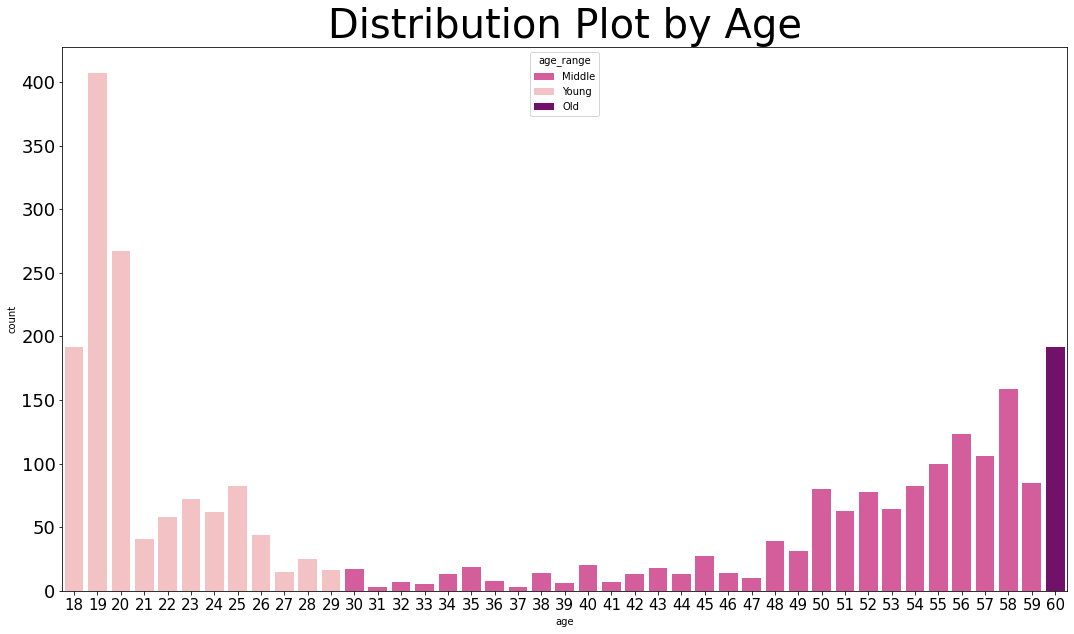

In [9]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

font_path = r'/opt/ml/code/NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=18)
mpl.rcParams['axes.unicode_minus'] = False
# /opt/ml/code/NanumBarunGothic.ttf


plt.figure(figsize=(18,10))
palette = [sns.color_palette("RdPu")[3],sns.color_palette("RdPu")[1],sns.color_palette("RdPu")[5]]
sns.countplot(x='age',data=train,hue='age_range',palette=palette,dodge=False)
# train.age_range.value_counts()
plt.title("Distribution Plot by Age",fontsize =40)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 18)
plt.show()

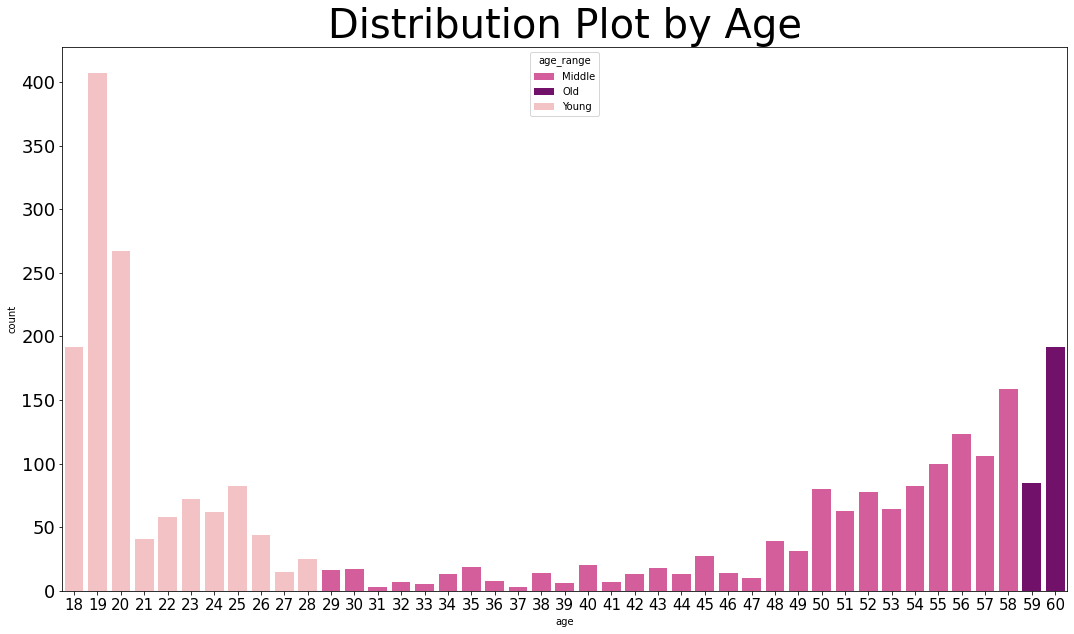

In [10]:
# 라벨링수정 후

train.loc[train[(train['age'] < 29) == True].index,'age_range'] = 'Young'
train.loc[train[((train['age']>= 29)== True) & ((train['age'] < 58 ) == True)].index,'age_range'] = 'Middle'
train.loc[train[(train['age'] >= 59) == True].index,'age_range'] = 'Old'


plt.figure(figsize=(18,10))
palette = [sns.color_palette("RdPu")[3],sns.color_palette("RdPu")[5],sns.color_palette("RdPu")[1]]
sns.countplot(x='age',data=train,hue='age_range',palette=palette,dodge=False)
# train.age_range.value_counts()
plt.title("Distribution Plot by Age",fontsize =40)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 18)
plt.show()

In [11]:
train

,id,gender,race,age,path,age_range
0,000001,female,Asian,45,000001_female_Asian_45,Middle
1,000002,female,Asian,52,000002_female_Asian_52,Middle
2,000004,male,Asian,54,000004_male_Asian_54,Middle
3,000005,female,Asian,58,000005_female_Asian_58,Middle
4,000006,female,Asian,59,000006_female_Asian_59,Old
...,...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19,Young
2696,006955,male,Asian,19,006955_male_Asian_19,Young
2697,006956,male,Asian,19,006956_male_Asian_19,Young
2698,006957,male,Asian,20,006957_male_Asian_20,Young


In [12]:
train['gender_age'] = 'unknown'

train.loc[train[(train['gender']=='female')&(train['age'] < 30) == True].index,'gender_age'] = 'Young_female'
train.loc[train[(train['gender']=='male')&(train['age'] < 30) == True].index,'gender_age'] = 'Young_male'
train.loc[train[(train['gender']=='female') & (train['age']>= 30) & (train['age'] < 60) == True].index,'gender_age'] = 'Middle_female'
train.loc[train[(train['gender']=='male') & (train['age']>= 30) & (train['age'] < 60) == True].index,'gender_age'] = 'Middle_male'
train.loc[train[(train['gender']=='female')&(train['age'] >= 60) == True].index,'gender_age'] = 'Old_female'
train.loc[train[(train['gender']=='male')&(train['age'] >= 60) == True].index,'gender_age'] = 'Old_male'

In [13]:
train.gender_age.value_counts() #1281 1227

Middle_female    817
Young_female     732
Young_male       549
Middle_male      410
Old_female       109
Old_male          83
Name: gender_age, dtype: int64

(-1.1299364844325601,
 1.162153781070407,
 -1.1144679979474827,
 1.1006889522832135)

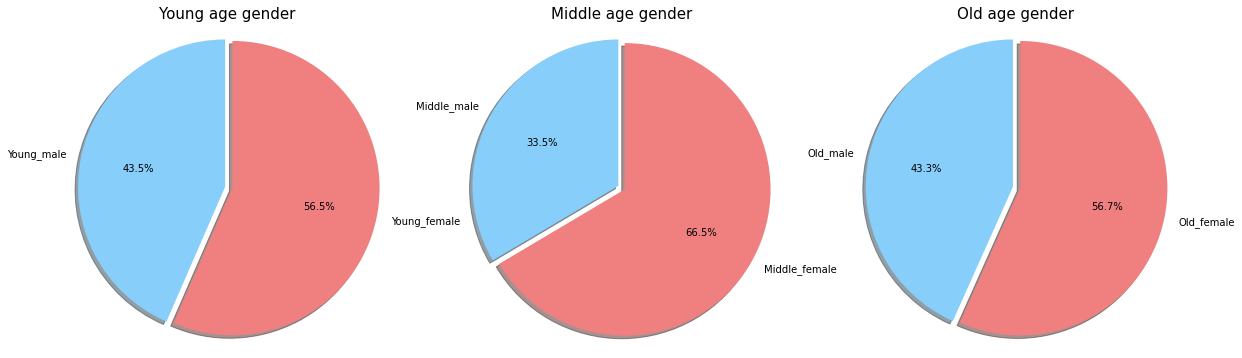

In [14]:
plt.figure(figsize=(20,6))
plt.subplot(131)
labels = ['Young_male', 'Young_female']
sizes = [0.439,0.571]
colors = [ 'lightskyblue', 'lightcoral']
explode = (0,0.05)
plt.title("Young age gender",fontsize=15)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')

plt.subplot(132)
labels = ['Middle_male', 'Middle_female']
sizes = [0.335,0.665]
colors = [ 'lightskyblue', 'lightcoral']
explode = (0,0.05)
plt.title("Middle age gender",fontsize=15)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
# plt.show()

plt.subplot(133)
labels = ['Old_male', 'Old_female']
sizes = [0.433,0.567]
colors = [ 'lightskyblue', 'lightcoral']
explode = (0.,0.05)
plt.title("Old age gender",fontsize=15)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
# plt.show()

In [15]:
dl = train_label

In [16]:
dl['wear'] = 'unkown'
# # train_label.loc[train_label[train_label['name'][:4] =='mask'].index,'wear'] = 'mask'
# for i in range(len(train_label)):
#     if train_label['name'][i][:4] in 'mask':
#         train_label['wear'] = 'mask'

#     elif train_label['name'][i][:4] == 'norm':
#         train_label['wear'] = 'normal'
        
#     elif train_label['name'][i][:4] == 'inco':
#         train_label['wear'] = 'incorrect'

In [17]:
dl.loc[dl[dl['name'] =='mask1.jpg'].index,'wear'] = 'mask'
dl.loc[dl[dl['name'] =='mask1.jpeg'].index,'wear'] = 'mask'
dl.loc[dl[dl['name'] =='mask1.png'].index,'wear'] = 'mask'

dl.loc[dl[dl['name'] =='mask2.jpg'].index,'wear'] = 'mask'
dl.loc[dl[dl['name'] =='mask2.jpeg'].index,'wear'] = 'mask'
dl.loc[dl[dl['name'] =='mask2.png'].index,'wear'] = 'mask'

dl.loc[dl[dl['name'] =='mask3.jpg'].index,'wear'] = 'mask'
dl.loc[dl[dl['name'] =='mask3.jpeg'].index,'wear'] = 'mask'
dl.loc[dl[dl['name'] =='mask3.png'].index,'wear'] = 'mask'

dl.loc[dl[dl['name'] =='mask4.jpg'].index,'wear'] = 'mask'
dl.loc[dl[dl['name'] =='mask4.jpeg'].index,'wear'] = 'mask'
dl.loc[dl[dl['name'] =='mask4.png'].index,'wear'] = 'mask'

dl.loc[dl[dl['name'] =='mask5.jpg'].index,'wear'] = 'mask'
dl.loc[dl[dl['name'] =='mask5.jpeg'].index,'wear'] = 'mask'
dl.loc[dl[dl['name'] =='mask5.png'].index,'wear'] = 'mask'

dl.loc[dl[dl['name'] =='mask6.jpg'].index,'wear'] = 'mask'
dl.loc[dl[dl['name'] =='mask6.jpeg'].index,'wear'] = 'mask'
dl.loc[dl[dl['name'] =='mask6.png'].index,'wear'] = 'mask'

dl.loc[dl[dl['name'] =='normal.jpg'].index,'wear'] = 'normal'
dl.loc[dl[dl['name'] =='normal.jpeg'].index,'wear'] = 'normal'
dl.loc[dl[dl['name'] =='normal.png'].index,'wear'] = 'normal'

dl.loc[dl[dl['name'] =='incorrect_mask.jpg'].index,'wear'] = 'incorrect'
dl.loc[dl[dl['name'] =='incorrect_mask.jpeg'].index,'wear'] = 'incorrect'
dl.loc[dl[dl['name'] =='incorrect_mask.png'].index,'wear'] = 'incorrect'

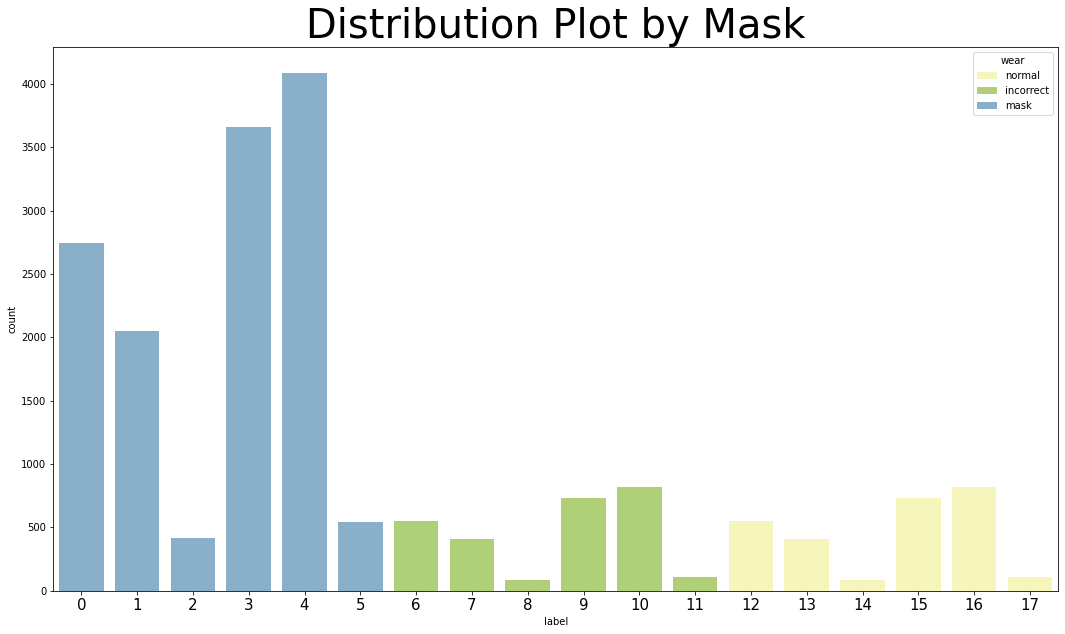

In [18]:
plt.figure(figsize=(18,10))
palette = [sns.color_palette("Set3")[1],sns.color_palette("Set3")[6],sns.color_palette("Set3")[4]]
# sns.color_palette("Set2")
sns.countplot(x='label',data=dl,hue='wear',palette=palette,dodge=False)
# train.age_range.value_counts()
plt.title("Distribution Plot by Mask",fontsize =40)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 10)
plt.show()

In [19]:
def get_ext(img_dir, img_id):
    """
    학습 데이터셋 이미지 폴더에는 여러 하위폴더로 구성되고, 이 하위폴더들에는 각 사람의 사진들이 들어가있습니다. 하위폴더에 속한 이미지의 확장자를 구하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름

    Returns:
        ext: 이미지의 확장자
    """
    filename = os.listdir(os.path.join(img_dir, img_id))[0]
    ext = os.path.splitext(filename)[-1].lower()
    return ext

In [20]:
df = train
imgs = []
img_id = df.iloc[500].path
ext = get_ext(cfg.img_dir, img_id)
for class_id in num2class:
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)))
    imgs.append(img)
imgs = np.array(imgs)

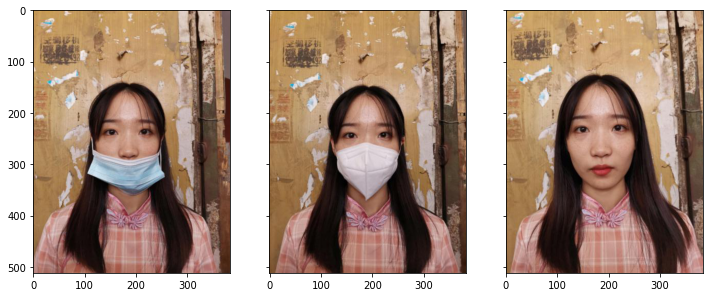

In [21]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 6))
axes[0].imshow(imgs[0])
axes[1].imshow(imgs[1])
axes[2].imshow(imgs[-1])
plt.show()

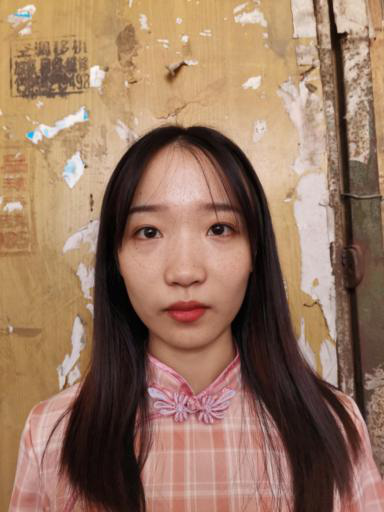

In [22]:
Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext))

In [46]:
from facenet_pytorch import MTCNN
device = torch.device('cuda')
mtcnn = MTCNN(keep_all=True, device=device)
new_img_dir = './input/data/train/new_imgs'
img_path = './input/data/eval/images'

cnt = 0

for paths in os.listdir(img_path):
    if paths[0] == '.': continue
    
    sub_dir = os.path.join(img_path, paths)
    # sub_dir = os.path.join(img_path)
    
    for imgs in os.listdir(sub_dir):
        if imgs[0] == '.': continue
        
        img_dir = os.path.join(sub_dir, imgs)
        img = cv2.imread(img_dir)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        #mtcnn 적용
        boxes,probs = mtcnn.detect(img)
        
        # boxes 확인
        if len(probs) > 1: 
            print(boxes)
        if not isinstance(boxes, np.ndarray):
            print('Nope!')
            # 직접 crop
            img=img[100:400, 50:350, :]
        
        # boexes size 확인
        else:
            xmin = int(boxes[0, 0])-30
            ymin = int(boxes[0, 1])-30
            xmax = int(boxes[0, 2])+30
            ymax = int(boxes[0, 3])+30
            
            if xmin < 0: xmin = 0
            if ymin < 0: ymin = 0
            if xmax > 384: xmax = 384
            if ymax > 512: ymax = 512
            
            img = img[ymin:ymax, xmin:xmax, :]
            
        tmp = os.path.join(new_img_dir, paths)
        cnt += 1
        if not os.path.exists(tmp):
            os.makedirs(tmp)
            
        plt.imsave(os.path.join(tmp, imgs), img)
        
print(cnt)


[[114.02377 126.96632 264.4614  320.47778]
 [167.30377 324.78458 235.85017 403.6976 ]]
[[134.05817 142.40215 259.7505  316.8338 ]
 [135.37103 333.52936 224.56006 442.01578]]
[[100.74331   166.2488    254.54039   350.22754  ]
 [ -1.1128038 227.68256    15.567443  250.29207  ]]
Nope!
[[118.29258 155.39005 272.50647 338.8281 ]
 [189.139   443.54727 207.59091 469.06757]]
Nope!
[[124.60446 150.64113 259.03802 325.03635]
 [ 49.64576  68.2208   70.11532  94.46649]]
[[ 98.1498  100.82474 285.833   342.27844]
 [153.0534  334.5786  210.24329 392.06906]]
[[101.0396  147.66357 272.2736  358.82748]
 [119.80277 325.67395 223.16042 436.54077]]
[[136.25047 198.56758 252.97195 338.36185]
 [166.08955 308.67548 271.31357 418.38028]]
[[105.136314  120.83875   284.01605   351.0789   ]
 [ -3.8166146 236.15036    24.571037  270.82498  ]]
[[124.83409  158.95992  284.61896  328.22357 ]
 [ 68.80978   69.832985  98.30154  105.034065]]
Nope!
[[ 81.684906  72.181404 320.12564  340.66144 ]
 [145.13782  313.43176  1

KeyboardInterrupt: 

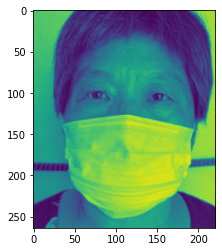

In [44]:
image = cv2.imread('/opt/ml/input/data/train/new_imgs/000008_female_Asian_58/mask3.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

Number of faces detected: 1
Number of faces detected: 1
Number of faces detected: 1


(([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

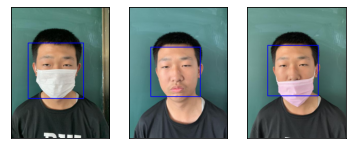

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
plt.subplot(131)
image = cv2.imread('/opt/ml/code/train/train/images_original/006700_male_Asian_19/mask3.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# xml = 'haarcascades/haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.2, 5)

print("Number of faces detected: " + str(len(faces)))

if len(faces):
    for (x,y,w,h) in faces:
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap='gray')
plt.xticks([]), plt.yticks([]) 

plt.subplot(132)
image = cv2.imread('/opt/ml/code/train/train/images_original/006700_male_Asian_19/normal.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# xml = 'haarcascades/haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.2, 5)

print("Number of faces detected: " + str(len(faces)))

if len(faces):
    for (x,y,w,h) in faces:
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap='gray')
plt.xticks([]), plt.yticks([]) 

plt.subplot(133)
image = cv2.imread('/opt/ml/code/train/train/images_original/006700_male_Asian_19/incorrect_mask.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# xml = 'haarcascades/haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.2, 5)

print("Number of faces detected: " + str(len(faces)))

if len(faces):
    for (x,y,w,h) in faces:
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap='gray')
plt.xticks([]), plt.yticks([]) 

In [37]:
from deepface.commons import functions
img1 = functions.detect_face('./input/data/train/images/000002_female_Asian_52/normal.jpg',(512,380,3))
img2 = functions.detect_face("./input/data/train/images/000002_female_Asian_52/mask4.jpg",(512,380,3))

AttributeError: 'str' object has no attribute 'shape'

In [32]:
from mtcnn import MTCNN
import cv2
detector = MTCNN()

img = cv2.imread("/opt/ml/input/data/train/images/000002_female_Asian_52/normal.jpg")
detections = detector.detect_faces(img)

for detection in detections:
    score = detection['confidence']
    if score &amp;amp;gt; 0.90:
        x,y,w,h = detection['box']
        detected_face = img[int(y):int(y+h), int(x):int(x+w)]

SyntaxError: invalid syntax (<ipython-input-32-8658fa604a0b>, line 10)

AttributeError: 'str' object has no attribute 'shape'